## CHANGING FROM RIAB TO PENDULUM

### Inverted Pendulum Swingup problem
https://gymnasium.farama.org/environments/classic_control/pendulum/ 

Observation space: 
- cos(theta), 
- sin(theta)  theta is the pendulum’s angle normalized between [-pi, pi]  , 
- angular velocity in range(-8,8) 

Action space: torque applied to free end +ve counter clockwise \
Goal: swing to upright position  (theta = 0 , x=1 y=0) - x and y on opposite axes - check diagram \ 
objective is to maintain the pendulum in the upright position \
Reward: $r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)$ \

The starting state is a random angle in [-pi, pi] and a random angular velocity in [-1,1]. \
The episode truncates at 200 time steps.

- 0 to 180 = [0,pi] and  180-360 [-pi,0]

https://gammamodels.github.io/ 
- reward and value estimates diagram #TODO https://github.com/jannerm/gamma-models/blob/main/scripts/gamma-pendulum.ipynb

# TODO

averaging all atoms gets SR of uniform policy ? (acc to Tmaze in paper)

rate maps - the pendulum would have predicted rate maps of sin(theta), cos(theta) and velocity (Dense 3)
each atom would have different biases

- Use of latent states
2. Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
3. Activations over layers - entropy of neuron - average over each dim

### Load all

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import model_viz_functions_pendulum as modelviz_pendulum_utils
import model_viz_loaders as modelviz_loaders
# from model_viz6_functions import plot_samples 


2024-09-09 05:46:24.084650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 05:46:24.084726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 05:46:24.084774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-09 05:46:25.148673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[05:46:26] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=36534;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=122290;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=384824;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=306933;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=707679;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=556582;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/sruthi/Documents/thesis/distributional-sr/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, se

In [3]:
import os
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

# import copy

### ENV and MODEL path and dataset

In [4]:
# env
ENVIRONMENT = "Pendulum-v1" 
model_path = "logdir_pendulum_200k" 
# model_path = "logdir-500k_pendulum" 

In [5]:
# import pathlib 
# import pickle 
# dataset_path = pathlib.Path("datasets/pendulum_test/sac/dataset.pkl")
# with open(dataset_path, "rb") as f:
#     dataset1 = pickle.load(f)

# folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)

print("Dataset observations shape: ",dataset.observation.shape)

Dataset observations shape:  (500001, 3)


In [6]:
env = envs.make(ENVIRONMENT)  #config.env
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

### Model stuff - restoring checkpoint

In [7]:
state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)

print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))
# num_state_dims is the expected number of input place cells
print(state.generator.apply_fn)  
# print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, 

[05:46:27] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=46056;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=787674;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

           INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=635166;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=974452;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=903062;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=630727;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir
debug latest_step 200000


[05:46:33] INFO     Restoring item from                                                         ]8;id=866841;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=512420;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir_pendulum_200k/200000                    
                    .                                                                                              

/home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=588792;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=976690;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Documents/thesis/distributional-sr/logdir_pendulum_200k/200000                    
                    .                                                                                              

Saved model state: Generator params shapes: {'params': {'model': {'Dense_0': {'bias': (10, 32), 'kernel': (10, 8, 32)}, 'Dense_1': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_2': {'bias': (10, 32), 'kernel': (10, 32, 32)}, 'Dense_3': {'bias': (10, 3), 'kernel': (10, 32, 3)}}}}
<bound method Module.apply of DistributionalSRGenerator(
    # attributes
    model = MLP(
        # attributes
        num_layers = 3
        num_hidden_units = 32
        num_outputs = None
        module = Dense
        activation = leaky_relu
        dtype = float32
        param_dtype = float32
    )
    num_atoms = 10
    num_state_dims = 3
)>


In [8]:
num_samples= 32 #config.plot_num_samples # Number of state samples the model should generate
num_outer=config.num_outer # Number of model atoms   
num_latent_dims= config.latent_dims # Dimension of input noise 
print('observation_spec shape:', env.observation_spec().shape[0], ' num_latent_dims ',num_latent_dims)
print(f'DSM model input (n_samples {num_samples}, n_atoms {num_outer}, atom_input {num_latent_dims+env.observation_spec().shape[0]}) ')

observation_spec shape: 3  num_latent_dims  5
DSM model input (n_samples 32, n_atoms 10, atom_input 8) 


### Source states

In [9]:
# from dsm import plotting
# saved_source_states = plotting.source_states(config.env) 
# # has 2 lists of 9 elements each - each element is a list of 2 elements  - states:[theta, thetadot] observations: [sin(theta), cos(theta), thetadot]
# # print('polar coords, angular velocity',saved_source_states[0]) 
# # print('cartesian coords, angular velocity',saved_source_states[1])
# sources_all = saved_source_states[1]

In [10]:
def get_states(n_steps, theta_range=[0,2*np.pi], thetadot_range=[-8,8]):
    """
        for # inputs from pi/2 to 3pi/2  - below the pendulum bar: get_states(50, theta_range = [np.pi/2, 3*np.pi/2],thetadot_range=[-4,4])
        returns `n_steps`^2 states from pendulum environment,
        sampling angle and angular velocity uniformly within environment bounds
    """
    theta_range = np.linspace(*theta_range, n_steps)
    thetadot_range = np.linspace(*thetadot_range, n_steps)[::-1]

    states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for thetadot in thetadot_range
        for theta in theta_range
    ])

    return states, theta_range, thetadot_range

def get_condition_states():
    """
        returns a few representative conditioning states
    """
    thetas = [np.pi/2, np.pi, np.pi*3/2]
    thetadots = [-4, 0, 4]

    condition_states = np.array([
        (np.cos(theta), np.sin(theta), thetadot)
        for theta in thetas
        for thetadot in thetadots
    ])
    
    return condition_states, thetas, thetadots

# sources_all, *_ = get_states(50)
# sources_all.shape

In [11]:
sources_all, *_ = get_condition_states()

In [12]:
# from dsm import rewards
# # for reward_fn_name, reward_fn in getattr(rewards, config.env).items():
# from dsm.plotting import utils as plot_utils
# reward_fn_name = 'Default'
# reward_fn = getattr(rewards, config.env)[reward_fn_name]
# reward_fn
def _angle_normalize(x: jax.Array) -> jax.Array:
    return ((x + jnp.pi) % (2 * jnp.pi)) - jnp.pi
def pendulum_no_action_penalty(states, a=None) -> jax.Array:
    del a
    if len(states) == 3:
        t = jnp.arctan2(states[1], states[0]) # angle to the vertical arctan2(sin_theta, cos_theta)
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif len(states)==2:
        t = states[0]
        return -(_angle_normalize(t) ** 2 + 0.1 * states[-1] ** 2)
    elif states.shape[1] == 3:
        cos_theta = states[:,0]
        sin_theta = states[:,1]
        thetadot = states[:,2]

        theta = np.arctan2(sin_theta, cos_theta)
        costs = _angle_normalize(theta)**2 + .1*thetadot**2 #+ .001*(u**2)

        return -costs

reward_fn = pendulum_no_action_penalty 

# plt.rcParams['figure.figsize'] = [2, 3]
# n_steps = 41
# queries, theta_range, thetadot_range = get_states(n_steps)
# rewards = reward_fn(queries)

# rewards_2d = rewards.reshape(n_steps, n_steps)
# plt.imshow(rewards_2d, aspect='auto', cmap='inferno')
# # plt.gca().invert_yaxis()
# plt.xticks([])
# plt.yticks([])
# plt.colorbar()
# # plt.tight_layout()
# # scatter = plt.contourf(theta_range, thetadot_range, rewards_2d, cmap='inferno')

### compute DSM samples

atom_input = latent+source_state <br>
DSM model input (n_samples, n_atoms, atom_input)

In [13]:
source_idx = 0
source_state_current = sources_all[source_idx]
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source_state_current, num_samples = 32
    )

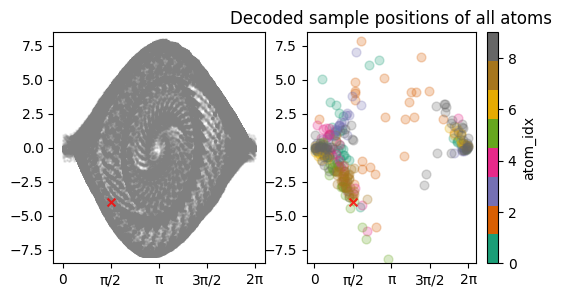

In [14]:
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=True, atom='all')

# img_dict = plotting.plot_samples(state.generator, jax.random.PRNGKey(0),config=config)
# src_idx = 0
# plot_key = list(img_dict.keys())[src_idx]
# sample_plotarray = img_dict[plot_key]
# plt.imshow(sample_plotarray)

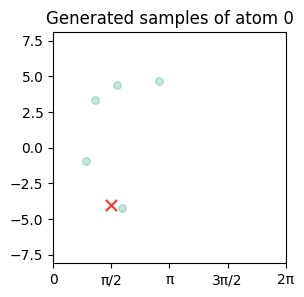

In [15]:
source, samples = modelviz_loaders.compute_DSM_samples_single_source(
        state.generator, jax.random.PRNGKey(0), config=config, source_state_current=source_state_current, num_samples = 5
    )
atom_idx = 0
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=atom_idx)


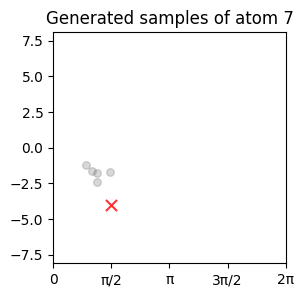

In [58]:
modelviz_pendulum_utils.plot_samples_dsm(samples, source, make_dataset=False, atom=7)


#### Exploring actions and rewards of the 10 atoms for the samples above from  one source state

DEBUG POLICY  <tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x76e16c12cf40>


[05:46:37] INFO     Converting library function __inference_converted_fun_tf_30                       ]8;id=455261;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py\tf2jax.py]8;;\:]8;id=10093;file:///home/sruthi/Documents/thesis/.venv/lib/python3.10/site-packages/tf2jax/_src/tf2jax.py#986\986]8;;\

DEBUG pure_policy_func  <tf2jax._src.tf2jax.AnnotatedFunction object at 0x76e16c12eec0> policy_params  {}


/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:
/home/sruthi/Documents/thesis/distributional-sr/dsm/datasets.py:84: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  def policy_fn(rng: jax.random.KeyArray, observation: jax.Array) -> tuple[jax.random.KeyArray, jax.Array]:


debug actions min max -0.99933285 0.9997991


Text(0.5, 0, 'Atom index')

Text(0, 0.5, 'Reward value')

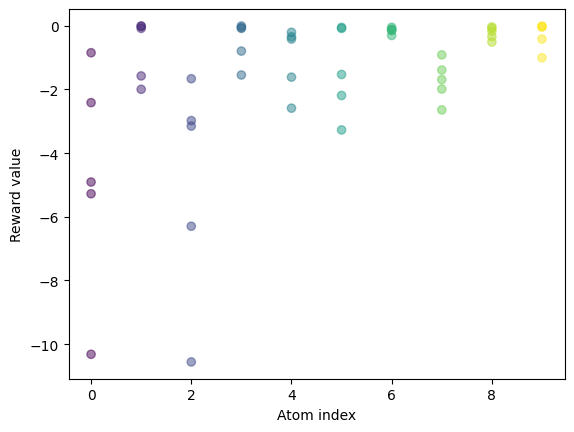

(10,)

<Axes: ylabel='Count'>

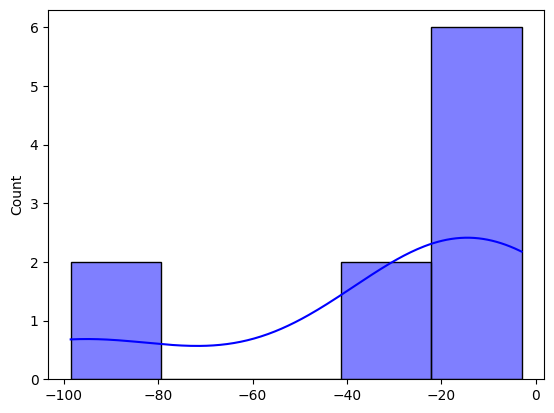

In [16]:
# Exploring actions and rewards of the 10 atoms for the samples above from  one source state

# plotting utils
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
atom_idx_values = np.arange(samples.shape[0])
norm = Normalize(vmin=min(atom_idx_values), vmax=max(atom_idx_values))
sm = ScalarMappable(cmap='tab10', norm=norm)

policy = datasets.make_policy(config.env)
def apply_policy_to_batch(batch):
    keys,samples = batch
    return jax.lax.map(lambda x: policy(x[0],x[1]),(keys,samples))
keys = jax.random.split(jax.random.PRNGKey(0), np.prod(samples.shape[:-1]))
keys = jnp.array(keys).reshape(*samples.shape[:-1], -1)
actions = jax.lax.map(apply_policy_to_batch, (keys,samples))[1]
print('debug actions min max',np.min(actions), np.max(actions))

# # Assuming actions[1] has shape (10, 64, 1, 1)
# # Reshape it to (10, 64)
# reshaped_actions = actions.reshape(actions.shape[0], -1)
# # for i in range(10):
# #     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
# x_coords = np.repeat(np.arange(reshaped_actions.shape[0]), reshaped_actions.shape[1])
# # Flatten reshaped_actions) for plotting
# flat_actions = reshaped_actions.flatten()
# plt.scatter(x_coords, flat_actions, c=x_coords, alpha=0.5, cmap='viridis')
# plt.xlabel('Atom index')
# plt.ylabel('Action value')
# plt.show()

rewards = jax.vmap(jax.vmap(reward_fn))(samples, actions).squeeze()

reshaped_rewards = rewards.reshape(rewards.shape[0], -1)
# for i in range(10):
#     plt.scatter([i]*len(reshaped_actions[i]), reshaped_actions[i])
x_coords = np.repeat(np.arange(reshaped_rewards.shape[0]), reshaped_rewards.shape[1])
# Flatten reshaped_actions) for plotting
flat_rewards = reshaped_rewards.flatten()
plt.scatter(x_coords, flat_rewards, c=x_coords, alpha=0.5, cmap='viridis')
plt.xlabel('Atom index')
plt.ylabel('Reward value')
plt.show()

reward_mean = rewards.mean(axis=-1) / (1.0 - config.gamma)  
reward_mean.shape
import seaborn as sns
sns.histplot(reward_mean, kde=True, color='blue')

## Experiments

#### ALL SOURCES _ PREDICTIONs

DSM model input (n_samples, n_atoms, state_dims + latent_dims)
To generate 1 sample , 1 atom's input = state_dims + random_latent_dims
1. All atoms - All source states - Two different latents (potentially unlimited number of latents) 
2. 1 source state - all atoms - 50 different latents?

In [17]:
sources_all, theta_all, thetadot_all = get_states(10) #get_condition_states()

/tmp/ipykernel_1350082/1245116148.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reversed_map = plt.cm.get_cmap('viridis') .reversed()


(100, 3)

Processing atoms:   0%|          | 0/10 [00:00<?, ?it/s]

Processing atoms: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


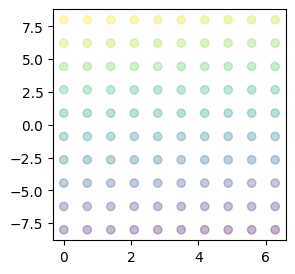

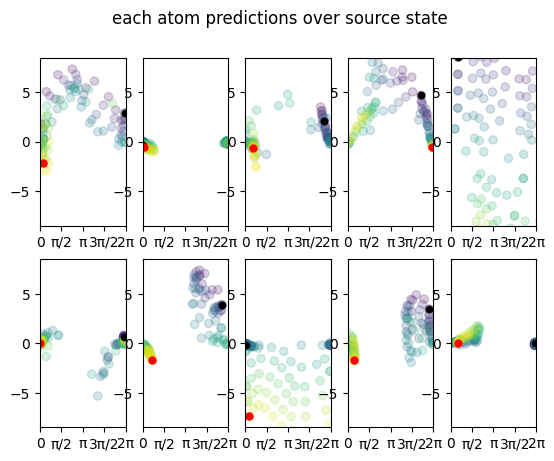

Processing atoms: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


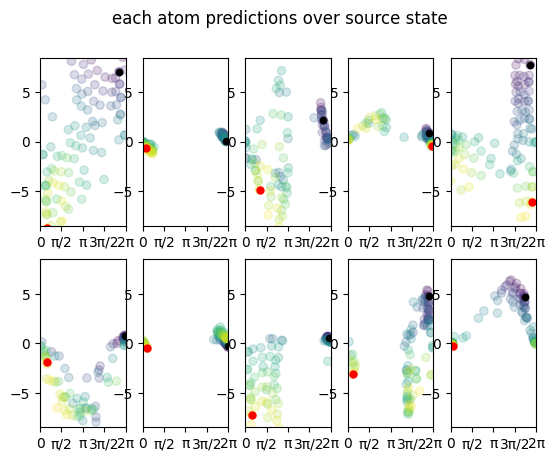

In [18]:
# All atoms - For the same source state - Two different latents (potentially unlimited number of latents) 
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
thetas = np.arctan2(sources_all[:, 1], sources_all[:, 0]) % (2 * np.pi)
velocities = sources_all[:, -1]
colors = range(len(thetas))  # Create a list of numbers from 0 to len(xs)-1
reversed_map = plt.cm.get_cmap('viridis') .reversed() 
scatter = axs.scatter(thetas, velocities, alpha=0.3, c=colors, cmap=reversed_map)  # Use the numbers as colors
sources_all.shape
latent_rng_seed = 0
modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
                              title='each atom predictions over source state')
latent_rng_seed = 2
modelviz_pendulum_utils.plot_predictions_atoms(config, latent_rng_seed, state.generator, sources_all, atoms_sel = 'all',
                              title='each atom predictions over source state')

In [19]:
#TODO ASK 1 atom - 1 source - 10 latent values - gives 10 ratemaps - how to quantify

### Dense 3 activations  - output ratemaps over cos(theta) , sin(theta), angular velocity

In [21]:
# All atoms - return specified layer activation - Plot rate map of neuron_idx
def explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed):
    zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 
    activations_layer_all_atoms = [] # of length num_ckpts
    for atom_num in range(config.num_outer):
        atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
        activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator, atom_params, sources_all,zs, layers)
        # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
        activations_layer_all_atoms.append(activations_layer) 
    return activations_layer_all_atoms

In [90]:
import importlib 
importlib.reload(modelviz_pendulum_utils)

<module 'model_viz_functions_pendulum' from '/home/sruthi/Documents/thesis/distributional-sr/model_viz_functions_pendulum.py'>

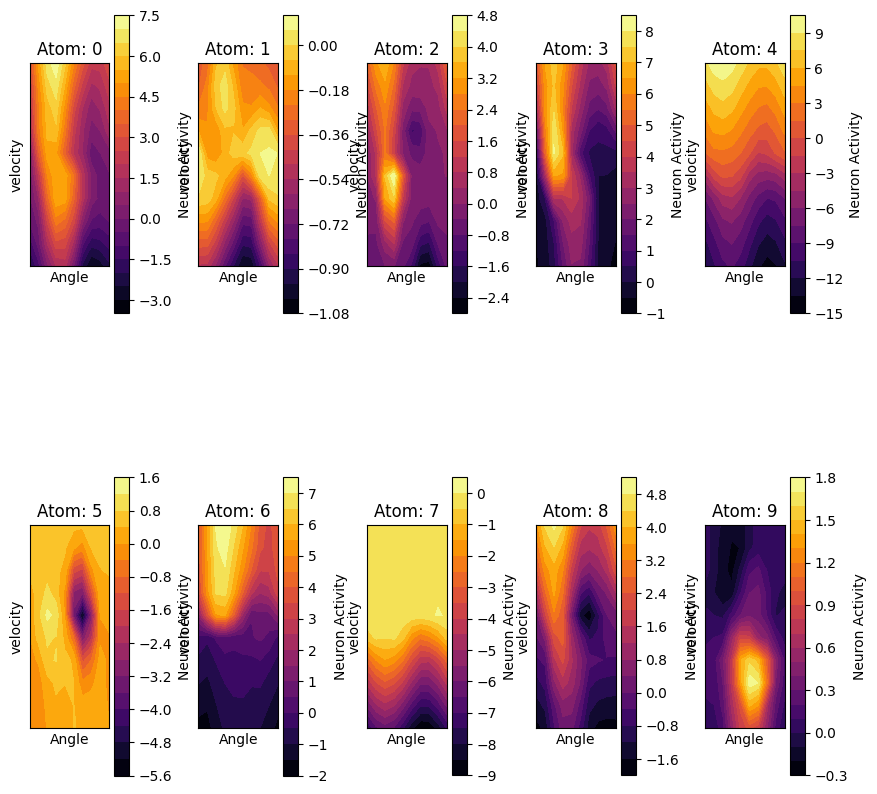

In [93]:
# All atoms - activation of neuron predicting angular velocity - 
layers = ['Dense_3',]
latent_rng_seed = 0 
neuron_idx=2 # angular velocity (ONE LATENT)
print('NEURON: 2 - Angular Velocity')
activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed)
modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, theta_all, thetadot_all, normalize=False)

# #TODO how to quantify angular velocity wrt different latents
# latent_rng_seed = 3 
# neuron_idx=2 # angular velocity (ONE LATENT)
# activations_layer_all_atoms = explore_all_atoms_specify_latent_layeridx(layers, latent_rng_seed)
# modelviz_pendulum_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, theta_all, thetadot_all)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" #"all"

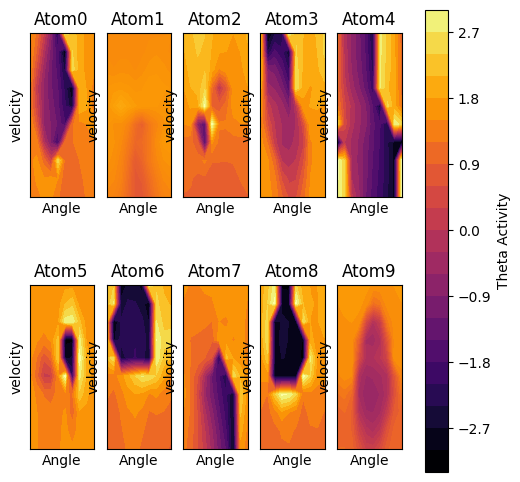

In [108]:
# Plot with respect to theta arctan(neuron1 output, neuron2 output)
# from mpl_toolkits.axes_grid1 import make_axes_locatable
n = len(activations_layer_all_atoms)
cols = 5 
rows = n // cols 
position = range(1,n + 1)
fig = plt.figure(figsize=(6,6))

# Find global min and max
global_min = -np.pi
global_max = np.pi
# global_min = np.min([np.min(activations_layer) for activations_layer in activations_layer_all_atoms])
# global_max = np.max([np.max(activations_layer) for activations_layer in activations_layer_all_atoms])
scatters = []
for k, activations_layer in enumerate(activations_layer_all_atoms): 
    ax = fig.add_subplot(rows, cols, position[k])
    ax.set_aspect('equal')
    label = f'Atom: {k}'
    theta = np.arctan2(activations_layer[:, 0], activations_layer[:, 1])
    activations_2d = theta.reshape(len(thetadot_all), len(theta_all))
    scatter = ax.contourf(theta_all, thetadot_all, activations_2d, cmap='inferno', levels=20, vmin=global_min, vmax=global_max)
    scatters.append(scatter)
    ax.set_aspect('equal')
    ax.set_title(f'Atom{k}')
    plt.xticks([]), plt.yticks([]) 
    ax.set_xlabel('Angle')
    ax.set_ylabel('velocity')

# Create colorbar as a common for all subplots.
fig.colorbar(scatters[0], ax=fig.get_axes(), label='Theta Activity')

plt.show()

## 1 atom

To generate 1 sample , 1 atom's input = state_dims + random_latent_dims

- Plot intermediate activations as 2D maps of neurons - theta (0-360) vs velocity - but model is trained with cos(theta),sin(theta),velocity \
2.1. Freeze latent and see with different source states and same latent? \
2.2 Change latents slightly - tiny changes? \
2.3 see which neurons dont change when latents change a lot
- Activations over layers - entropy of neuron - average over each dim

In [109]:
# Selecting the model atom to use, and extracting its parameters , also get corresponding input
#TODO
atom_i = 7  # ith atom
num_outer = config.num_outer 
atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, atom_i, num_outer)
print("Extracted params shapes for the i-th model:")
# print_params_shapes(atom_params)
print(jax.tree_map(jnp.shape, atom_params))

Extracted params shapes for the i-th model:
{'Dense_0': {'bias': (32,), 'kernel': (8, 32)}, 'Dense_1': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_2': {'bias': (32,), 'kernel': (32, 32)}, 'Dense_3': {'bias': (3,), 'kernel': (32, 3)}}


In [110]:
# All intermediate layers
layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
latent_rng_seed = 0
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
activations_alllayers = modelviz_pendulum_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, sources_all, zs, layers)

for keys,values in zip(activations_alllayers.keys(), activations_alllayers.values()):
    print(keys, values.shape)
    
import joblib
joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_atom{atom_i}_latent{latent_rng_seed}.pkl')

Dense_0 (100, 32)
Dense_1 (100, 32)
Dense_2 (100, 32)
Dense_3 (100, 3)


In [46]:
# layers = ['Dense_3',]
# latent_rng_seed = 0
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (num_latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_layer = modelviz_pendulum_utils.compute_activation_layer_all_sources(state.generator,atom_params, sources_all, zs, layers)
# activations_layer.shape

(100, 3)

In [52]:
importlib.reload(modelviz_pendulum_utils)

<module 'model_viz_functions_pendulum' from '/home/sruthi/Documents/thesis/distributional-sr/model_viz_functions_pendulum.py'>

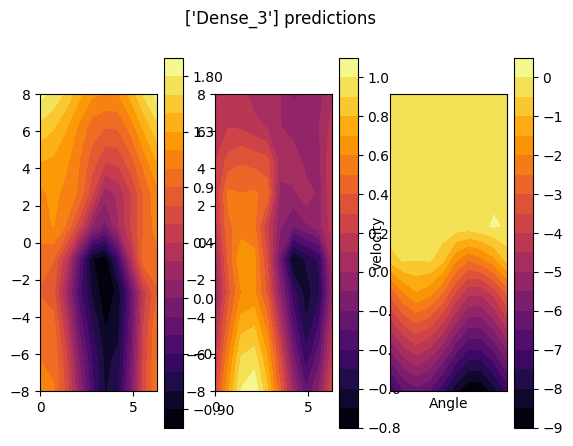

In [53]:
modelviz_pendulum_utils.plot_neuron_activations(activations_layer, 'all', f'{layers} predictions', theta_all, thetadot_all)


## Entropy

In [43]:
from scipy.stats import entropy

def compute_entropy_activations(activations, label=None, plot_normalized = False,normalize=True):
    # Apply to handle negative activations and normalize
    if normalize:
        normalized_activations = activations / np.sum(activations, axis=1, keepdims=True)
    # print('debug',normalized_activations)
    if plot_normalized:
        plt.plot(normalized_activations, label=label)
    # entropy = -np.sum(normalized_activations * np.log(normalized_activations + 1e-9))/np.log(2)  # Adding a small value to prevent log(0)
    # return entropy #/normalized_activations.shape[0]
    activation_entropy =  entropy(normalized_activations, base=len(normalized_activations)) #TODO - ask standard practice of base
    return activation_entropy

In [ ]:
neuron_idx =0 
activations_selected = activations_alllayers['Dense_3'][:,neuron_idx]
activations_2d = activations_selected.reshape(len(z), len(angles))

# Plot the activations
plt.figure(figsize=(10, 6))
plt.contourf(angles, z, activations_2d, cmap='viridis', levels=20)
plt.colorbar(label='Activation')
plt.xlabel('Angles (radians)')
plt.ylabel('Z')
plt.title('Neuron Activations')
plt.show()

distr_velocity = np.mean(activations_2d, axis=1)
distr_angles = np.mean(activations_2d, axis=0)
plt.plot(distr_angles,label='angles orig')
plt.plot(distr_velocity,label='velocity orig')

a_entropy = compute_entropy_activations(distr_angles,plot_normalized=1,label='angles')
print("Entropy of neuron activations wrt angles:", a_entropy)
v_entropy = compute_entropy_activations(distr_velocity,plot_normalized=1,label='velocity')
print("Entropy of neuron activations wrt velocity:", v_entropy)
plt.legend()

# Delete

#### 1 atom - efffect of different Zs - latents

In [ ]:
# - here,  test different latents
layers = ['Dense_3',]

activations_layer_randomz = []
for i in range(3):
    zs = jax.random.normal(jax.random.PRNGKey(i), (config.latent_dims,))
    # zs = np.ones((config.latent_dims)) *np.exp(i) # latent_rng not used if zs provided
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator,atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

# Plotting all the neurons
# for i in range(len(activations_layer_randomz)):
#     neuron_idx = np.arange(activations_layer_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)
#     # neuron_idx=0
#     # modelviz_utils.plot_neuron_activations(activations_layer_randomz[i],neuron_idx,layers,xpos,ypos)

neuron_idx=40
print('NEURON: ', neuron_idx)
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_randomz, 'latent rng key', neuron_idx, xpos, ypos)
PCs.plot_rate_map(chosen_neurons=[f'{neuron_idx}'])
## to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_randomz[0],neuron_idx,layers,xpos,ypos)



In [ ]:
atom_idx = 9  # ith atom
# layers = ['Dense_3',]
# latent_rng_seed = 0 
# zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

# atom_params = modelviz_utils.extract_params_ith_atom(state.generator, atom_idx, config.num_outer)
# activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
# print(f'activations_layer.shape: {activations_layer.shape}')
# neuron_idx = np.arange(activations_layer.shape[-1])
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)
# neuron_idx=40
# modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)


#### All ATOMS - Plot rate map of neuron_idx

In [ ]:
# All atoms - Plot rate map of neuron_idx
layers = ['Dense_3',]
latent_rng_seed = 0 
zs = jax.random.normal(jax.random.PRNGKey(latent_rng_seed), (config.latent_dims,)) 

activations_layer_all_atoms = [] # of length num_ckpts
for atom_num in range(config.num_outer):
    atom_params = modelviz_utils.extract_params_ith_atom(state.generator, atom_num, config.num_outer )
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(_,50) for Dense_3
    activations_layer_all_atoms.append(activations_layer)

#TODO - select neuron_idx
neuron_idx=1 # neuron_idx = 'all' or in range(0, activations_layer.shape[1])
print(f'Layer: {layers} - Neuron: {neuron_idx}')
modelviz_utils.plot_neuron_ratemaps_from_activationlayerlist(activations_layer_all_atoms, 'Atom', neuron_idx, xpos, ypos)

# to see scale
# modelviz_utils.plot_neuron_activations(activations_layer_all_atoms[0],neuron_idx,layers,xpos,ypos)


In [ ]:
layers = ['Dense_0','Dense_1','Dense_2']

layers

### Other Dense layers

#### Dense 0,1,2

In [ ]:
layers = ['Dense_2',]

activations_layer_randomz = []
for i in range(1):
    rng = jax.random.PRNGKey(i)
    zs = jax.random.normal(rng, (config.latent_dims,))
    print('zs',zs)
    activations_layer = modelviz_utils.compute_activation_layer_all_sources(state.generator, atom_params, source_states_env,zs, layers)
    activations_layer_randomz.append(activations_layer)

    print(activations_layer.shape)
    neuron_idx = np.arange(0, min(50,activations_layer.shape[1]))
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,layers,xpos,ypos)


In [ ]:
### All intermediates

# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (num_latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(state.generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )

# joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent0.pkl')

## Later

- decoding from hidden neuron to start and end state, 
- tsne/ umap
- entropy

Model will generate different successor states from the same source state (effect of different latents?, try giving all 5 same?). \
Different source states may generate same successor states (same x,y positions) 

xs[:,:,-3:] #same - context - source state , rest noise latent dims  \
 xs_atom #shape (8)

In [ ]:
# from model_viz6_functions import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(state.generator, atom_params, source_states_env, layers,num_samples,num_latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)